In [9]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
from oxygen_fugacity import OxygenFugacity
from fugacity import Fugacity
from sulfur_partition_coefficients import PartitionCoefficient
from melt_composition import MeltComposition
from S_Fe import Sulfur_Iron
from SCSS_model import Sulfur_Saturation
from scipy.special import erf
import math as math
import PySulfSat as ss
import matplotlib as mpl
import periodictable as pt
import seaborn as sb
import sulfur as sf
import matplotlib as mpl

def S6_total_OandM(composition, T_C, del_FMQ):
    T_K = T_C + 273.15
    """o2: log10"""
    wtsio2 = composition["SiO2_liq_mage"]
    wttio2 = composition["TiO2_liq_mage"]
    wtal2o3 = composition["Al2O3_liq_mage"]
    wtfeo = composition["FeO_liq_mage"]
    wtmno = composition["MnO_liq_mage"]
    wtmgo = composition["MgO_liq_mage"]
    wtcao = composition["CaO_liq_mage"]
    wtna2o = composition["Na2O_liq_mage"]
    wtk2o = composition["K2O_liq_mage"]
    wtp2o5 = composition["P2O5_liq_mage"]

    xtot = wtsio2/60.08+wttio2/79.9+wtal2o3/50.98+wtfeo/71.85+wtmgo/40.32+ wtcao/56.08+wtna2o/30.99+wtk2o/47.1+wtmno/70.94
    
    xna = (wtna2o/30.99)/xtot
    xmg = (wtmgo/40.32)/xtot
    xal = (wtal2o3/50.98)/xtot
    xsi = (wtsio2/60.08)/xtot
    xk = (wtk2o/47.1)/xtot
    xca = (wtcao/56.08)/xtot
    xti = (wttio2/79.9)/xtot
    xmn = (wtmno/70.94)/xtot
    xfet = (wtfeo/71.85)/xtot
    fe2_fetotal = 1/(1 + 10**(0.25*del_FMQ - 1.36 + 2.4*xca + 2*xna + 3.7*xk))
    xferrous = xfet * fe2_fetotal
    fo2 = del_FMQ - 25050/T_K+8.5
    
    c_sulfide = 8.77-23590/T_K+(1673/T_K)*(6.7*(xna+xk)+4.9*xmg+8.1*xca+8.9*(xfet+xmn)+5*xti+1.8*xal
                                                   -22.2*xti*(xfet+xmn)+7.2*((xfet+xmn)*xsi))-2.06*erf(-7.2*(xfet+xmn))
    c_sulfate = (-8.02) +(21100+44000*xna+18700*xmg+4300*xal+35600*xca+44200*xk+16500*xferrous+12600*xmn)/T_K
    lnk = (-55921)/T_K+25.07-0.6465*np.log(T_K) # SO3/S
    lnrs =(c_sulfate - lnk - c_sulfide) + 2 * np.log(10)*fo2
    rs =1-1/(1+np.exp(lnrs))

    return rs



In [16]:
data = pd.read_csv('../data/S_model_LLDs_delFMQ0-2.csv')

data['MnO_liq_mage'] = 0
data['P2O5_liq_mage'] = 0

data.iloc[:, 4:] = data.iloc[:, 4:]*100 # convert to wt%
data['melt_frac_wt'] = data['melt_frac_wt']*100

# Delete problematic data with low melt fraction
data = data.drop(data[data.melt_frac_wt < 10].index)

# Model setup
n_llds = len(data['P_kbar'].unique()) # Number of LLDs in dataframe
s_initial = np.random.uniform(1000,3000,n_llds) # initial sulfur in the melt (ppm) range (s_min, s_max, n)
Cu_initial = np.random.uniform(50,100,n_llds) # initial Cu from MORB range given in Lee et al. 
Au_initial = np.random.uniform(0.003,0.005,n_llds) # initial Au from Li and Audetat 2013
Ag_initial = np.random.uniform(0.025,0.040,n_llds) # initial Ag from Li and Audetat 2013
DCu_minmelt = 0.1 # partition coefficient for Cu mineral/melt
DAg_minmelt = 0 # partition coefficient for Cu mineral/melt
DAu_minmelt = 0 # partition coefficient for Cu mineral/melt


llds = [data.groupby('P_kbar').get_group(x) for x in data.groupby('P_kbar').groups]

outputs = []
n = 0
for lld in llds:

    lld['S_melt'] = s_initial[n] * (lld['melt_frac_wt']/100)**(0-1) # Assuming sulfur is completely incompatible estimate its % increase in the melt

    # New dataframe compatibly with ss
    data_scss = lld[['SiO2_liq_mage', 'TiO2_liq_mage', 'Al2O3_liq_mage', 'FeO_liq_mage', 'MgO_liq_mage', 'CaO_liq_mage', 'Na2O_liq_mage', 'MnO_liq_mage', 'P2O5_liq_mage', 'K2O_liq_mage', 'H2O_liq_mage']]
    data_scss.columns = ['SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq', 'FeOt_Liq', 'MgO_Liq', 'CaO_Liq', 'Na2O_Liq', 'MnO_Liq','P2O5_Liq', 'K2O_Liq', 'H2O_Liq']

    # Li & Zhang SCSS
    LZ2022_SCSS = ss.calculate_LiZhang2022_SCSS(df=data_scss,T_K=lld['T_C']+273.15, P_kbar=lld['P_kbar'], Fe_FeNiCu_Sulf=0.65, logfo2=sf.calc_logfo2(lld['T_C'], lld['delta_QFM']))
    lld['SCSS_Tot'] = LZ2022_SCSS['SCSS_Tot']

    # O'Neill and Mavrogenes S6+/Stotal
    lld['S6_total'] = S6_total_OandM(composition=lld, T_C = lld['T_C'], del_FMQ=lld['delta_QFM'])

    # Convert bulk sulfur in melt to S2- in the melt
    lld['S2_melt'] = lld['S_melt']*(1-lld['S6_total'])

    # Sulfate content at sulfate saturation Zajacz & Tsay (2019)
    ZT2019_SCAS = ss.calculate_ZT2019_SCAS(df=data_scss, T_K=lld['T_C']+273.15)
    lld['S6_melt'] = lld['S_melt']*lld['S6_total']
    sulfate_saturated = np.where(lld['S6_melt']>ZT2019_SCAS['SCAS6_ppm'], 'Saturated', 'Undersaturated')

    # Now we calcualte the S melt, which will be buffered by SCSS or SCAS if it sulfide or sulfate saturated
    # if sulfide saturated and not sulfate saturated
    lld['S_melt'] = np.where((lld['SCSS_Tot'] < lld['S2_melt']) & (lld['S6_melt'] < ZT2019_SCAS['SCAS6_ppm']), lld['SCSS_Tot'], lld['S_melt'])
    
    # if sulfate saturated and not sulfide saturated
    lld['S_melt'] = np.where((lld['SCSS_Tot'] > lld['S2_melt']) & (lld['S6_melt'] > ZT2019_SCAS['SCAS6_ppm']), ZT2019_SCAS['SCAS6_ppm'], lld['S_melt'])
    lld['Andyrite before Sulfide'] = np.where((lld['SCSS_Tot'] > lld['S2_melt']) & (lld['S6_melt'] > ZT2019_SCAS['SCAS6_ppm']), 1, 0)
    
    # if both sulfide and sulfate saturated, take the sulfur content which is lowest 
    lld['S_melt'] = np.where((lld['S6_melt']>ZT2019_SCAS['SCAS6_ppm']) & (lld['SCSS_Tot'] > lld['S2_melt']) & (ZT2019_SCAS['SCAS6_ppm'] < lld['SCSS_Tot']),
                              ZT2019_SCAS['SCAS6_ppm'], lld['S_melt'])
    lld['S_melt'] = np.where((lld['S6_melt']>ZT2019_SCAS['SCAS6_ppm']) & (lld['SCSS_Tot'] > lld['S2_melt']) & (ZT2019_SCAS['SCAS6_ppm'] > lld['SCSS_Tot']),
                              lld['SCSS_Tot'], lld['S_melt'])
    

    lld['mass_mss'] = (s_initial[n] * 1-lld['SCSS_Tot'] * lld['melt_frac_wt']/100)/10**6  *  pt.formula("FeS").mass/pt.formula("S").mass

    bool =  np.where(lld['SCSS_Tot'] > lld['S2_melt'], 0, 1)
    lld['mass_mss'] = bool*lld['mass_mss'] # boolean if sulphide is saturated

    # Calculate bulk partition coefficient
    D_Cu = DCu_minmelt * (100 - lld['melt_frac_wt']) / 100 + sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Cu', sulfur_phase = 'MSS') * lld['mass_mss']
    D_Au = DAu_minmelt * (100 - lld['melt_frac_wt']) / 100 + sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Au', sulfur_phase = 'MSS') * lld['mass_mss']
    D_Ag = DAg_minmelt * (100 - lld['melt_frac_wt']) / 100 + sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Ag', sulfur_phase = 'MSS') * lld['mass_mss']

    # Equilbirium crystallisation equation
    lld['Cu_melt'] = (Cu_initial[n] / (D_Cu + lld['melt_frac_wt'] / 100 * (1 - D_Cu)))
    lld['Au_melt'] = (Au_initial[n] / (D_Au + lld['melt_frac_wt'] / 100 * (1 - D_Au)))
    lld['Ag_melt'] = (Ag_initial[n] / (D_Ag + lld['melt_frac_wt'] / 100 * (1 - D_Ag)))

    outputs.append(lld)
    n = n + 1
data_sulf = pd.concat(outputs, axis=0, ignore_index=True)

Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
r

In [17]:
data_sulf['Mg#_sol'] = ((1/40.32)*data_sulf['MgO_sol_mage'])/(((0.9/79.8)*data_sulf['FeO_sol_mage'])+((1/40.32)*data_sulf['MgO_sol_mage']))
data_sulf['Mg#_liq'] = ((1/40.32)*data_sulf['MgO_liq_mage'])/(((0.9/79.8)*data_sulf['FeO_liq_mage'])+((1/40.32)*data_sulf['MgO_liq_mage']))


llds = [data_sulf.groupby('P_kbar').get_group(x) for x in data_sulf.groupby('P_kbar').groups]

ss_mg = np.zeros(len(llds)) # Empty list of Mg# at sulfide saturation
dqfm = np.zeros(len(llds))
ss_sio2 = np.zeros(len(llds))
ss_melt_frac = np.zeros(len(llds))
sa_mg = np.zeros(len(llds)) # Empty list of Mg# at sulfide saturation
sa_sio2 = np.zeros(len(llds))
sa_melt_frac = np.zeros(len(llds))

n = 0
for lld in llds:
    
    lld = lld.reset_index(drop=True)
    # Store the point at which sulfide saturates 
    bool =  np.where(lld['SCSS_Tot'] > lld['S2_melt'], 0, 1)
    if 1 in bool:
        ss_index = list(bool).index(1)
        ss_mg[n] = lld['Mg#_liq'].iloc[ss_index]
        ss_sio2[n] = lld['SiO2_liq_mage'].iloc[ss_index]
        ss_melt_frac[n] = lld['melt_frac_wt'].iloc[ss_index]
    else:
        ss_index = 'Undersaturated'
        ss_mg[n] = 0 # If you never saturate in sulfide use 0
        ss_sio2[n] = 0 # If you never saturate in sulfide use 0
        ss_melt_frac[n] = 0 
    dqfm[n] = lld['delta_QFM'].iloc[0]

    # Store the point at which anydrite saturates
    bool2 =  lld['Andyrite before Sulfide']
    if 1 in bool2.values:
        sa_index = list(bool2.astype(int)).index(1)
        sa_mg[n] = lld['Mg#_liq'].iloc[sa_index]
        sa_sio2[n] = lld['SiO2_liq_mage'].iloc[sa_index]
        sa_melt_frac[n] = lld['melt_frac_wt'].iloc[sa_index]

    else:
        sa_index = 'Undersaturated'
        sa_mg[n] = 0 # If you never saturate in sulfide use 0
        sa_sio2[n] = 0 # If you never saturate in sulfide use 0
        sa_melt_frac[n] = 0 
        
    n = n + 1

ss_df = pd.concat([pd.Series(dqfm, name = 'dQFM'), pd.Series(ss_sio2, name = 'SiO2 at SS'), pd.Series(ss_mg, name = '#Mg at SS'), 
                   pd.Series(s_initial, name = "Initial S"), pd.Series(ss_melt_frac, name = 'Melt Fraction')], axis = 1)

sa_df = pd.concat([pd.Series(dqfm, name = 'dQFM'), pd.Series(sa_sio2, name = 'SiO2 at SS'), pd.Series(sa_mg, name = '#Mg at AS'), 
                   pd.Series(s_initial, name = "Initial S"), pd.Series(sa_melt_frac, name = 'Melt Fraction')], axis = 1)

ss_df = ss_df.dropna()
sa_df = sa_df.dropna()

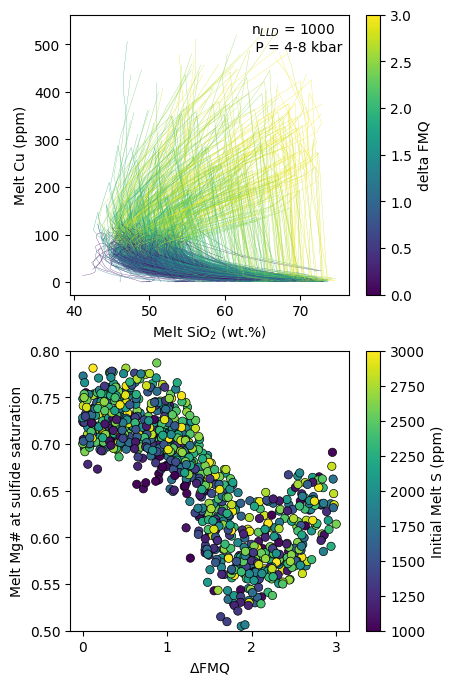

In [18]:
from matplotlib import colors
from matplotlib import cm
norm = colors.Normalize(vmin=np.round(s_initial.min(), -2), vmax=np.round(s_initial.max(), -2))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
cmap.set_array([])

fig, axs = plt.subplots(2,1, figsize = (4.5,8))

sb.scatterplot(x=ss_df['dQFM'], y=ss_df['#Mg at SS'], edgecolor = 'black', c  = cmap.to_rgba(ss_df["Initial S"]), ax = axs[1])
axs[1].set_xlabel('$\Delta$FMQ')
axs[1].set_ylabel('Melt Mg# at sulfide saturation')

norm = plt.Normalize(np.round(s_initial.min(), -2), np.round(s_initial.max(), -2))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

axs[1].figure.colorbar(sm, label = 'Initial Melt S (ppm)', ax = axs[1])
axs[1].set_ylim([0.5,0.8])

# Color scale
norm = mpl.colors.Normalize(vmin=data['delta_QFM'].min(), vmax=data['delta_QFM'].max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
cmap.set_array([])

for lld in llds:
    axs[0].plot(lld['SiO2_liq_mage'], lld['Cu_melt'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2)

norm = plt.Normalize(vmin=round(data['delta_QFM'].min(),1), vmax=round(data['delta_QFM'].max(),1))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
# sub_ax = plt.axes([0.99, 0.3, 0.02, 0.5]) # add a small custom axis
axs[0].figure.colorbar(sm, label = 'delta FMQ', ax = axs[0])

axs[0].set_ylabel('Melt Cu (ppm)')
axs[0].set_xlabel('Melt SiO$_{2}$ (wt.%)')

axs[0].annotate(xy = (0.65,0.87), text = 'n$_{LLD}$ = %1d \n P = %1d-%1d kbar' % (len(llds), data['P_kbar'].min(), data['P_kbar'].max()), xycoords = 'axes fraction')

plt.show()

In [12]:
# Whole rock Cu data for arcs

lt_df = pd.read_csv('Lee_Tang_Appendix.csv')
lt_df = lt_df[lt_df['Cu'].notna()]
thick = lt_df[lt_df['Calculated crustal thickness (km)'] > 50]
print(np.quantile(thick['Cu'], 0.05), np.quantile(thick['Cu'], 0.95))
thin = lt_df[lt_df['Calculated crustal thickness (km)'] < 30]
print(np.quantile(thin['Cu'], 0.05), np.quantile(thin['Cu'], 0.95))

# Create 4% bins for SiO2
bin_edges = np.arange(45, 75+2, 2)  # Define bin edges
thick['SiO2_bins'] = pd.cut(thick['SiO2'], bins=bin_edges)

# Group by bins and calculate the average Cu values
binned_data = thick.groupby('SiO2_bins')['Cu'].mean().reset_index()

# Extract bin labels and averages
bin_labels = binned_data['SiO2_bins'].astype(str)  # Bin ranges as strings
average_cu_thick = binned_data['Cu']
print(average_cu_thick)

# Create 4% bins for SiO2
bin_edges = np.arange(45, 75+2, 2)  # Define bin edges
thin['SiO2_bins'] = pd.cut(thin['SiO2'], bins=bin_edges)

# Group by bins and calculate the average Cu values
binned_data = thin.groupby('SiO2_bins')['Cu'].mean().reset_index()

# Extract bin labels and averages
bin_labels = binned_data['SiO2_bins'].astype(str)  # Bin ranges as strings
average_cu_thin = binned_data['Cu']

x = (bin_edges+1)[:-1]

# Create 4% bins for SiO2
bin_edges = np.arange(45, 75+2, 2)  # Define bin edges
lt_df['SiO2_bins'] = pd.cut(lt_df['SiO2'], bins=bin_edges)

# Group by bins and calculate the average Cu values
binned_data_mean = lt_df.groupby('SiO2_bins')['Cu'].mean().reset_index()
binned_data_lq = lt_df.groupby('SiO2_bins')['Cu'].quantile(0.05).reset_index()
binned_data_uq = lt_df.groupby('SiO2_bins')['Cu'].quantile(0.95).reset_index()

# Extract bin labels and averages
bin_labels = binned_data['SiO2_bins'].astype(str)  # Bin ranges as strings
average_cu_all = binned_data_mean['Cu']

x = (bin_edges+1)[:-1]

4.0 92.0
8.766071810000003 174.0
0           NaN
1     67.076471
2     68.659182
3     64.455715
4     61.868335
5     41.688885
6     40.801988
7     30.491444
8     28.530078
9     26.667077
10    36.750837
11    15.406281
12    15.125893
13    37.313828
14     6.033219
Name: Cu, dtype: float64


/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_2641/1742492225.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = thick.groupby('SiO2_bins')['Cu'].mean().reset_index()
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_2641/1742492225.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = thin.groupby('SiO2_bins')['Cu'].mean().reset_index()
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_2641/1742492225.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to re

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_2641/840831335.py:10: SyntaxWarning: invalid escape sequence '\D'
  axs[0].set_xlabel('$\Delta$FMQ')
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_2641/840831335.py:32: SyntaxWarning: invalid escape sequence '\D'
  axs[1].figure.colorbar(sm, label = '$\Delta$FMQ', ax = axs[1])


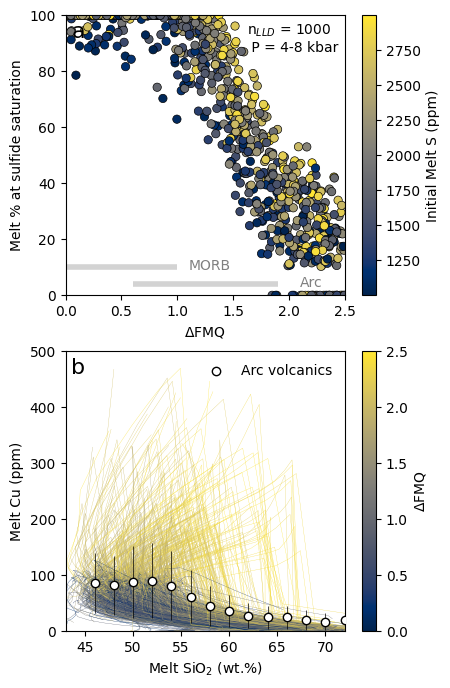

In [14]:
from matplotlib import colors
from matplotlib import cm
norm = colors.Normalize(vmin=s_initial.min(), vmax=s_initial.max())
cmap = cm.ScalarMappable(norm=norm, cmap=cm.cividis)
cmap.set_array([])

fig, axs = plt.subplots(2,1, figsize = (4.5,8))

sb.scatterplot(x=ss_df['dQFM'], y=ss_df['Melt Fraction'], edgecolor = 'black', c  = cmap.to_rgba(ss_df["Initial S"]), ax = axs[0])
axs[0].set_xlabel('$\Delta$FMQ')
axs[0].set_ylabel('Melt % at sulfide saturation')

norm = plt.Normalize(s_initial.min(), s_initial.max())
sm = plt.cm.ScalarMappable(cmap="cividis", norm=norm)
sm.set_array([])

axs[0].figure.colorbar(sm, label = 'Initial Melt S (ppm)', ax = axs[0])
axs[0].set_ylim([0,100])

# Color scale
norm = mpl.colors.Normalize(vmin=data['delta_QFM'].min(), vmax=data['delta_QFM'].max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis)
cmap.set_array([])

for lld in llds:
    axs[1].plot(lld['SiO2_liq_mage'], lld['Cu_melt'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2)

norm = plt.Normalize(vmin=round(data['delta_QFM'].min(),1), vmax=round(data['delta_QFM'].max(),1))
sm = plt.cm.ScalarMappable(cmap="cividis", norm=norm)
sm.set_array([])
# sub_ax = plt.axes([0.99, 0.3, 0.02, 0.5]) # add a small custom axis
axs[1].figure.colorbar(sm, label = '$\Delta$FMQ', ax = axs[1])

axs[1].set_ylabel('Melt Cu (ppm)')
axs[1].set_xlabel('Melt SiO$_{2}$ (wt.%)')

axs[1].set_ylim([0, 500])
axs[0].set_ylim([0, 100])
axs[0].set_xlim([0, 2.5])
axs[1].set_xlim([43,72])

axs[0].annotate(xy = (0.65,0.87), text = 'n$_{LLD}$ = %1d \n P = %1d-%1d kbar' % (len(llds), data['P_kbar'].min(), data['P_kbar'].max()), xycoords = 'axes fraction')

axs[0].annotate(xy = (0.02, 0.92), text = 'a', fontsize = 16, xycoords = 'axes fraction')
axs[1].annotate(xy = (0.02, 0.92), text = 'b', fontsize = 16, xycoords = 'axes fraction')

# axs[0].vlines(72, np.percentile(porphyry_mi['Cu'], 5), np.percentile(porphyry_mi['Cu'], 95), color = 'lightgray', linewidth = 3)

# axs[0].annotate(xy = (71.5, np.percentile(porphyry_mi['Cu'], 5) - 100), text = 'PCD MIs', fontsize = 9, rotation = 90)

# axs[0].vlines(73, np.percentile(barren_mi['Cu'], 5), np.percentile(barren_mi['Cu'], 95), color = 'lightgray', linewidth = 3) # Bar showing MI Cu content

sb.kdeplot(data=barren_mi, x="SiO2", y="Cu", levels=[0.05], fill=False, color = 'lightgray', clip=((0, None), (0, None)), ax = axs[1])

# axs[0].annotate(xy = (74, 80), text = 'Primitive Arc MIs', fontsize = 9, rotation = 90)
axs[1].annotate(xy = (50, 300), text = 'PMIs', fontsize = 9, rotation = 300, color = 'gray')

# axs[0].scatter(porphyry_mi['SiO2'], porphyry_mi['Cu'], color = 'darkred', zorder = 100, edgecolor = 'black', alpha = 0.5)
# axs[0].scatter(barren_mi['SiO2'], barren_mi['Cu'], color = 'white', edgecolor = 'black', zorder = 100, alpha = 0.5)

# axs[0].scatter(x, average_cu_thin, zorder = 100, color = 'white', edgecolor = 'black')
# axs[0].scatter(x, average_cu_thick, zorder = 100, color = 'blue', edgecolor = 'black')
axs[1].errorbar(x= x, y = average_cu_all, yerr = average_cu_all-binned_data_lq['Cu'], zorder = 100,color = 'black', linewidth = 0.5, ls = 'none')
axs[1].scatter(x, average_cu_all, zorder = 100, color = 'white', edgecolor = 'black', label = 'Arc volcanics')


axs[0].hlines(4, 0.6, 1.9, color = 'lightgray', linewidth = 4)
axs[0].hlines(10, 0, 1.0, color = 'lightgray', linewidth = 4)

axs[0].annotate(xy = (1.1, 9), text = 'MORB', color = 'gray')
axs[0].annotate(xy = (2.1, 3), text = 'Arc', color = 'gray')

axs[1].annotate(xy = (2.1, 3), text = 'Arc', color = 'gray')
axs[1].legend(loc = 'best', framealpha = 0)

plt.savefig('Seminar_MAGEMin_SS_Model.png', dpi = 1200)

plt.show()

In [7]:
mi_data = pd.read_csv('MeltInclusions_Cu.csv')
mi_data['Cu'] = pd.to_numeric(mi_data['Cu'], errors = 'coerce')
mi_data = mi_data[(mi_data['Host'] == 'Olivine') | (mi_data['Host'] == 'Clinopyroxene')]
mi_data = mi_data[~((mi_data['Location'] == 'Santa Rita') & (mi_data['Analysis'] != 'Zhang and Audetat'))]
mi_data = mi_data[mi_data['Cu'].notna()]

porphyry_mi = mi_data[(mi_data['Location'] == 'Bingham Canyon') | (mi_data['Location'] == 'Santa Rita')]
barren_mi = mi_data[(mi_data['Location'] != 'Bingham Canyon') & (mi_data['Location'] != 'Santa Rita')]
print(barren_mi)

      Location                Analysis Sample type     Host  \
122  Santorini    Vaggelli et al. 2009         NaN  Olivine   
128  Santorini    Vaggelli et al. 2009         NaN  Olivine   
129  Santorini    Vaggelli et al. 2009         NaN  Olivine   
130  Santorini    Vaggelli et al. 2009         NaN  Olivine   
132  Santorini    Vaggelli et al. 2009         NaN  Olivine   
..         ...                     ...         ...      ...   
256  Kamchatka  Portnyagin et al. 2017         NaN  Olivine   
257  Kamchatka  Portnyagin et al. 2017         NaN  Olivine   
258  Kamchatka  Portnyagin et al. 2017         NaN  Olivine   
259  Kamchatka  Portnyagin et al. 2017         NaN  Olivine   
260  Kamchatka  Portnyagin et al. 2017         NaN  Olivine   

                  Rock Sample name  Na2O   MgO  Al2O3   SiO2   K2O    CaO  \
122  Basaltic andesite         NaN  2.22  3.92  20.63  48.41  0.26  13.23   
128  Basaltic andesite         NaN  2.80  4.67  19.50  48.85  0.29  13.71   
129  Basalti

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_4143/2793749865.py:8: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel('$\Delta$FMQ')


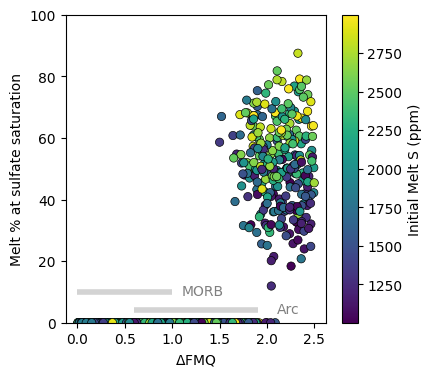

In [26]:
fig, ax = plt.subplots(1,1, figsize = (4.2,4))

norm = colors.Normalize(vmin=s_initial.min(), vmax=s_initial.max())
cmap = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
cmap.set_array([])

sb.scatterplot(x=sa_df['dQFM'], y=sa_df['Melt Fraction'], edgecolor = 'black', c  = cmap.to_rgba(sa_df["Initial S"]), ax = ax)
ax.set_xlabel('$\Delta$FMQ')
ax.set_ylabel('Melt % at sulfate saturation')

norm = plt.Normalize(s_initial.min(), s_initial.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

ax.figure.colorbar(sm, label = 'Initial Melt S (ppm)', ax = ax)
ax.set_ylim([0,100])

ax.hlines(4, 0.6, 1.9, color = 'lightgray', linewidth = 4)
ax.hlines(10, 0, 1.0, color = 'lightgray', linewidth = 4)

ax.annotate(xy = (1.1, 9), text = 'MORB', color = 'gray')
ax.annotate(xy = (2.1, 3), text = 'Arc', color = 'gray')

plt.savefig('Melt%_at_SCAS.png', dpi = 1200, bbox_inches="tight")
plt.show()


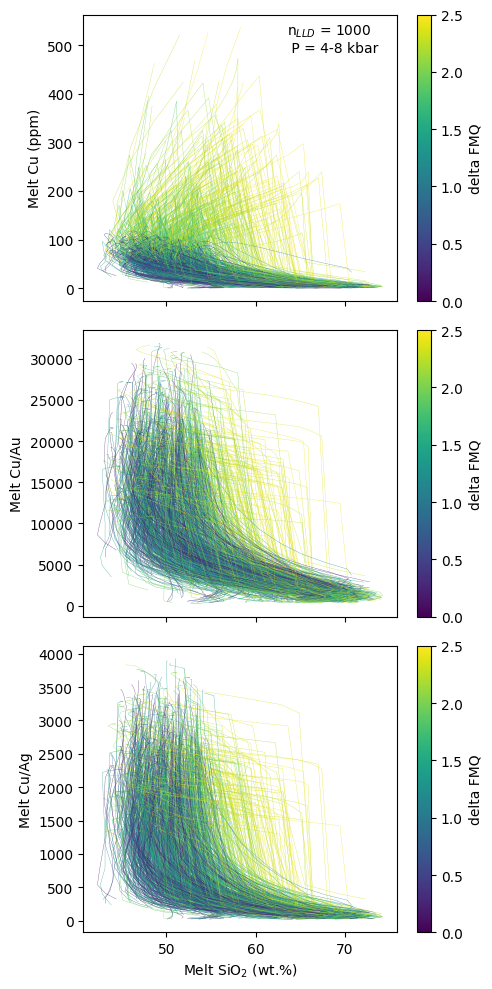

In [19]:
from matplotlib import colors
from matplotlib import cm
norm = colors.Normalize(vmin=np.round(s_initial.min(), -2), vmax=np.round(s_initial.max(), -2))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
cmap.set_array([])

fig, axs = plt.subplots(3,1, figsize = (5,10), sharex = True)


# Color scale
norm = mpl.colors.Normalize(vmin=data['delta_QFM'].min(), vmax=data['delta_QFM'].max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
cmap.set_array([])

for lld in llds:
    axs[0].plot(lld['SiO2_liq_mage'], lld['Cu_melt'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2)
    axs[1].plot(lld['SiO2_liq_mage'], lld['Cu_melt']/lld['Au_melt'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2)
    axs[2].plot(lld['SiO2_liq_mage'], lld['Cu_melt']/lld['Ag_melt'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2)

norm = plt.Normalize(vmin=round(data['delta_QFM'].min(),1), vmax=round(data['delta_QFM'].max(),1))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
# sub_ax = plt.axes([0.99, 0.3, 0.02, 0.5]) # add a small custom axis
axs[0].figure.colorbar(sm, label = 'delta FMQ', ax = axs[0])
axs[1].figure.colorbar(sm, label = 'delta FMQ', ax = axs[1])
axs[2].figure.colorbar(sm, label = 'delta FMQ', ax = axs[2])


axs[0].set_ylabel('Melt Cu (ppm)')
axs[1].set_ylabel('Melt Cu/Au')
axs[2].set_ylabel('Melt Cu/Ag')
axs[2].set_xlabel('Melt SiO$_{2}$ (wt.%)')

axs[0].annotate(xy = (0.65,0.87), text = 'n$_{LLD}$ = %1d \n P = %1d-%1d kbar' % (len(llds), data['P_kbar'].min(), data['P_kbar'].max()), xycoords = 'axes fraction')

plt.tight_layout()
plt.savefig('SModel_CuAuAg.png', dpi = 200)
plt.show()

In [8]:
barren_mi



,Location,Analysis,Sample type,Host,Rock,Sample name,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,MnO,FeO tot,Total,Cu
122,Santorini,Vaggelli et al. 2009,NaN,Olivine,Basaltic andesite,NaN,2.22,3.92,20.63,48.41,0.26,13.23,0.72,0.13,6.63,96.20,32.34
128,Santorini,Vaggelli et al. 2009,NaN,Olivine,Basaltic andesite,NaN,2.80,4.67,19.50,48.85,0.29,13.71,0.80,0.15,5.40,96.27,93.94
129,Santorini,Vaggelli et al. 2009,NaN,Olivine,Basaltic andesite,NaN,2.72,4.29,19.41,47.53,0.22,14.00,0.80,0.05,6.56,95.63,119.50
130,Santorini,Vaggelli et al. 2009,NaN,Olivine,Basaltic andesite,NaN,2.54,4.19,20.03,47.57,0.23,14.31,0.77,0.12,5.49,95.35,102.97
132,Santorini,Vaggelli et al. 2009,NaN,Olivine,Basaltic andesite,NaN,2.26,5.44,18.29,48.66,0.11,14.79,0.76,0.14,5.68,96.13,94.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,Kamchatka,Portnyagin et al. 2017,NaN,Olivine,Basalt,NaN,NaN,NaN,NaN,54.38,NaN,NaN,NaN,NaN,NaN,NaN,47.00
257,Kamchatka,Portnyagin et al. 2017,NaN,Olivine,Basalt,NaN,NaN,NaN,NaN,54.57,NaN,NaN,NaN,NaN,NaN,NaN,59.00
258,Kamchatka,Portnyagin et al. 2017,NaN,Olivine,Basalt,NaN,NaN,NaN,NaN,54.59,NaN,NaN,NaN,NaN,NaN,NaN,55.00
259,Kamchatka,Portnyagin et al. 2017,NaN,Olivine,Basalt,NaN,NaN,NaN,NaN,54.23,NaN,NaN,NaN,NaN,NaN,NaN,57.00
